# PA2 Problem 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import os
# os.chdir('/content/drive/MyDrive/2_pose_estimation')
# !python main.py

In [3]:
import os
import sys
sys.path.append(os.path.abspath('/content/drive/MyDrive/2_pose_estimation'))

from model import *
import torch
import numpy as np
import torchvision
import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import math
import torch.nn as nn
import torch.optim as optim

from glob import glob
import pandas
import matplotlib.pyplot as plt

device = 'cuda:0'
num_joints = 21

In [4]:
class Dataset(Dataset):
    def __init__(self, method=None):
        self.root = '/content/drive/MyDrive/2_pose_estimation/dataset/'
        self.x_data = []
        self.y_data = []
        if method == 'train':
            self.root = self.root + 'train/'
            self.img_path = sorted(glob(self.root + 'rgb/*.jpg'))

        elif method == 'test':
            self.root = self.root + 'test/'
            self.img_path = sorted(glob(self.root + 'rgb/*.jpg'))

        for i in tqdm.tqdm(range(len(self.img_path))):
            img = cv2.imread(self.img_path[i], cv2.IMREAD_COLOR)
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            self.x_data.append(img)

            num = self.img_path[i].split('.')[0].split('/')[-1]
            img_pkl = self.root + 'meta/' + str(num) + '.pkl'
            pkl = pandas.read_pickle(img_pkl)
            coords_2d = pkl['coords_2d']
            self.y_data.append(coords_2d)

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        transform1 = torchvision.transforms.ToTensor()
        new_x_data = transform1(self.x_data[idx])

        return new_x_data, self.y_data[idx]

In [5]:
class Tester(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self._build_model()

        self.root = '/content/drive/MyDrive/2_pose_estimation/dataset/'

        # Load of pretrained_weight file
        weight_PATH = '/content/drive/MyDrive/2_pose_estimation/dataset/pretrained_weight.pth'
        self.poseNet.load_state_dict(torch.load(weight_PATH))

        print("Testing...")

    def _build_model(self):
        # 2d pose estimator
        poseNet = CPM2DPose()
        self.poseNet = poseNet.to(device)

        print('Finish build model.')

    def heatmap2skeleton(self, heatmapsPoseNet):
        skeletons = np.zeros((heatmapsPoseNet.shape[0], heatmapsPoseNet.shape[1], 2))
        for m in range(heatmapsPoseNet.shape[0]):
            for i in range(heatmapsPoseNet.shape[1]):
                u, v = np.unravel_index(np.argmax(heatmapsPoseNet[m][i]), (32, 32))
                skeletons[m, i, 0] = u * 8
                skeletons[m, i, 1] = v * 8
        return skeletons

    @staticmethod
    def plot_hand(coords_hw, axis, color_fixed=None, linewidth='1'):
        colors = np.array([[0., 0., 1.],
                           [0., 0., 1.],
                           [0., 0., 1.],
                           [0., 0., 1.],
                           [1., 0., 1.],
                           [1., 0., 1.],
                           [1., 0., 1.],
                           [1., 0., 1.],
                           [1., 0., 0.],
                           [1., 0., 0.],
                           [1., 0., 0.],
                           [1., 0., 0.],
                           [0., 1., 0.],
                           [0., 1., 0.],
                           [0., 1., 0.],
                           [0., 1., 0.],
                           [1., 0.5, 0.],
                           [1., 0.5, 0.],
                           [1., 0.5, 0.],
                           [1., 0.5, 0.]])
        bones = [((1, 0), colors[0, :]),
                 ((2, 1), colors[1, :]),
                 ((3, 2), colors[2, :]),
                 ((4, 3), colors[3, :]),
                 ((0, 5), colors[4, :]),
                 ((5, 6), colors[5, :]),
                 ((6, 7), colors[6, :]),
                 ((7, 8), colors[7, :]),
                 ((0, 9), colors[8, :]),
                 ((9, 10), colors[9, :]),
                 ((10, 11), colors[10, :]),
                 ((11, 12), colors[11, :]),
                 ((0, 13), colors[12, :]),
                 ((13, 14), colors[13, :]),
                 ((14, 15), colors[14, :]),
                 ((15, 16), colors[15, :]),
                 ((0, 17), colors[16, :]),
                 ((17, 18), colors[17, :]),
                 ((18, 19), colors[18, :]),
                 ((19, 20), colors[19, :])]
        for connection, color in bones:
            coord1 = coords_hw[connection[0], :]
            coord2 = coords_hw[connection[1], :]
            coords = np.stack([coord1, coord2])
            if color_fixed is None:
                axis.plot(coords[:, 1], coords[:, 0], color=color, linewidth=linewidth)
            else:
                axis.plot(coords[:, 1], coords[:, 0], color_fixed, linewidth=linewidth)

    # test '106.png' image, origin code
    def test106(self):
        path = self.root + 'test/rgb/106.jpg'
        pkl_path = self.root + 'test/meta/106.pkl'
        print(path)
        print(pkl_path)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])
        transform1 = torchvision.transforms.ToTensor()
        x_data = transform1(img)
        pkl = pandas.read_pickle(pkl_path)
        y_test = pkl['coords_2d']

        self.poseNet.eval()

        print("Testing 106.jpg heatmap")

        print(x_data.size())

        heatmapsPoseNet = self.poseNet(x_data.unsqueeze(0).cuda()).cpu().detach().numpy()
        heatmap = np.transpose(heatmapsPoseNet[0], (1, 2, 0))

        plt.rcParams['figure.figsize'] = [12, 5]
        for i in range(num_joints):
            ax = plt.subplot(3, 7, i + 1)
            ax.imshow(heatmap[:, :, i])
        plt.savefig(self.root + 'heatmap.png')
        plt.show()

        print("Testing 106.jpg heatmap")

        ax = plt.subplot(1, 1, 1)
        ax.imshow(img)
        pred = self.heatmap2skeleton(heatmapsPoseNet)[0]
        self.plot_hand(pred, ax)
        error = self.calc_error(y_test, pred)
        print(f"Error is {error}")
        plt.savefig(self.root + 'results.png') 
        plt.show()

    # test all images
    def test(self):
        totalError = 0
        for i in range(500):
            img_path = self.root + 'test/rgb/%d.jpg' % (i)
            pkl_path = self.root + 'test/meta/%d.pkl' % (i)
            print(img_path)

            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            transform1 = torchvision.transforms.ToTensor()
            x_data = transform1(img)
            pkl = pandas.read_pickle(pkl_path)
            y_test = pkl['coords_2d']

            self.poseNet.eval()


            heatmapsPoseNet = self.poseNet(x_data.unsqueeze(0).cuda()).cpu().detach().numpy()
            heatmap = np.transpose(heatmapsPoseNet[0], (1, 2, 0))

            pred = self.heatmap2skeleton(heatmapsPoseNet)[0]
            error = self.calc_error(y_test, pred)
            print(f"Testing {i}-th image's error is {error}")
            totalError += error

        print(f"Total Error is {totalError/500}")

    # Prob1 - 3)
    def calc_error(self, gt, pred):
        k = 21 # num of keypoints
        err = 0
        for i in range(k):
            err += math.sqrt(math.pow((gt[i][0] - pred[i][0]),2) + math.pow((gt[i][1] - pred[i][1]),2)) # calculate Loss

        err = err/k # Loss average of keypoints
        return err

In [6]:
def main():
    epochs = 60
    batchSize = 16
    learningRate = 1e-5

    # trainer = Trainer(epochs, batchSize, learningRate)
    # trainer.train()

    tester = Tester(batchSize)
    # Prob1 - 1) & 2)
    tester.test106()
    # Prob1 - 4)
    tester.test()

Finish build model.
Testing...
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/106.jpg
/content/drive/MyDrive/2_pose_estimation/dataset/test/meta/106.pkl
Testing 106.jpg heatmap
torch.Size([3, 256, 256])


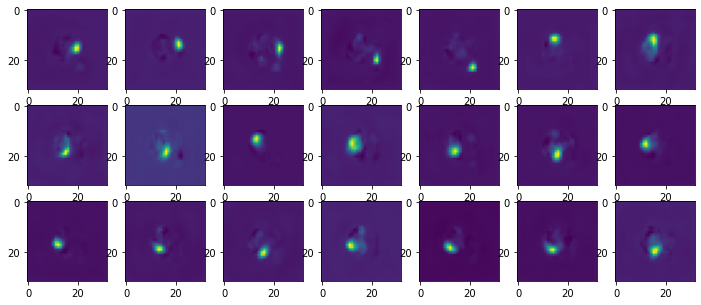

Testing 106.jpg heatmap
Error is 11.913604723320782


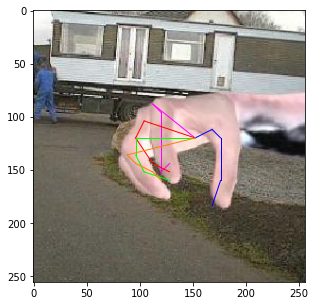

/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/0.jpg
Testing 0-th image's error is 57.66479025779912
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/1.jpg
Testing 1-th image's error is 10.878121586641532
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/2.jpg
Testing 2-th image's error is 21.998594504762927
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/3.jpg
Testing 3-th image's error is 42.90298992041422
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/4.jpg
Testing 4-th image's error is 24.60365074156147
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/5.jpg
Testing 5-th image's error is 8.859807612912068
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/6.jpg
Testing 6-th image's error is 9.376239102893528
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/7.jpg
Testing 7-th image's error is 17.242627566389803
/content/drive/MyDrive/2_pose_estimation/dataset/test/rgb/8.jpg
Testing 8-th image's error is 11.1092

In [7]:
if __name__ == '__main__':
    main()